# Natural Processing Languagge

[Simone Lombardini](https://sites.google.com/view/simone-lombardini/home-page) - June 2020


Natural Language Processing (NLP) is the area of research in Artificial Intelligence focused on processing and using Text and Speech data. 

This notebook I use data from the [Effectiveness Review in Jordan](https://policy-practice.oxfam.org.uk/publications/livelihoods-in-the-zaatari-camp-impact-evaluation-of-oxfams-cash-for-work-activ-620883) to explore how to conduct text description, pre-processing, Bags of Words, Latent Dirichlet Allocation (LDA), and Sentiment Analysis. I conclude with some visualizations.

In [1]:
# basic
import os
import pandas as pd
import numpy as np    
import datetime as dt

# graphs
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
# Set graphic parameters
sns.set(style="darkgrid", context="paper")

# text analysis
import string 
import re 
import nltk
import regex

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from textblob import TextBlob

# word clouds
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# word frequency
from collections import Counter

In [2]:
df = pd.read_stata('npl_jordan.dta')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1405 entries, 0 to 1404
Data columns (total 8 columns):
seekingx        1350 non-null float32
seekingy        1350 non-null float32
outcome         1329 non-null float32
recomend        1325 non-null float32
workwhat        1405 non-null object
workwhere       1405 non-null object
workyn          1405 non-null object
openquestion    1405 non-null object
dtypes: float32(4), object(4)
memory usage: 76.8+ KB


In [4]:
df.head()

,seekingx,seekingy,outcome,recomend,workwhat,workwhere,workyn,openquestion
0,0.140083,0.094898,0.39,0.76,Work_Paid_NotCFW,Work Inside,No,"since arriving, no job depite extensive search..."
1,0.356449,0.325931,0.06,0.95,Work_CFW_Ox,Work Inside,Yes,since I came in 2013 I was depressed and despe...
2,0.532594,0.181710,0.14,0.92,Work_Paid_NotCFW,Work Inside,No,Ahmad arrived 5 years ago and started looking ...
3,0.231623,0.047291,0.06,0.93,Work_CFW_Ox,Work Inside,Yes,I came to Jordan and then got married and star...
4,0.500694,0.244718,0.23,1.00,Work_CFW_Ox,Work Inside,Yes,I worked with Oxfam as a raising awareness and...


The variables of interest are:
* **openquestion** This is an open text field. The question was `Can you share an example of trying to access paid work since you arrived in the camp?` 
* **workwhat** This is a multiple-choice question. It asked the repondent to specify if the story is about: `Cash for work (with Oxfam)`, `Cash for work (with other agency)`, `Other work paid in money (not CFW)`, `Other work paid in exchange of goods (e.g. food, equipment, etc.)`, `Other work paid in exchange of services (e.g. childcare, trading skills, helping out, etc.)`, `Other work`
* **workwhere** A multiple-choice question to specify if the work was outside or inside the camp. 
* **workyn** A multiple-choice quesiton to specify if the respondent did carry out this work (even if it was temporaty)
* **outcome** This question is asking from a value to zero to 100 to which extent the respondent achieved the outcome they were trying to achieve in their story. Where 0 is `entirely` and 100 is `not at all`
* **recomend** This quesiton is asking from a value to zero to 100 if the respondent would recommend to other friends in this situation to pursue similar work to the one in your story? Where 0 is `not at all` and 100 is `entirealy`

## 1) Text analysis

In [5]:
df.openquestion.head()

0    since arriving, no job depite extensive search...
1    since I came in 2013 I was depressed and despe...
2    Ahmad arrived 5 years ago and started looking ...
3    I came to Jordan and then got married and star...
4    I worked with Oxfam as a raising awareness and...
Name: openquestion, dtype: object

as there are still some non-latin characters we remove non-latin characters from the text

In [6]:
df.openquestion[2]

'Ahmad arrived 5 years ago and started looking for a job with all organisations the worked with OXFAM as a Smith for a year. then his contract has ended and he is trying to find another job                                     Ø¬Ø§Ø¡ Ø§Ø\xadÙ\x85Ø¯ Ù\x85Ù'

In [7]:
def removenonlatin(text):
  text = re.sub("'", "",text)
  text = re.sub("(\\d|\\W)+"," ",text)
  text = re.sub(r'[^\x00-\x7f]',r'', text) 
  return "".join(text)

In [8]:
df['openquestion2'] = df.openquestion.apply(removenonlatin)

In [9]:
df.openquestion2[2]

'Ahmad arrived years ago and started looking for a job with all organisations the worked with OXFAM as a Smith for a year then his contract has ended and he is trying to find another job         '

### Word counts

In [10]:
text = " ".join(msg for msg in df.openquestion2)
print ("There are total of {} words in the 1405 responses.".format(len(text)))

There are total of 234570 words in the 1405 responses.


### Sring length 
Are repondents with sories about work outside the camp providing longer responses than respondents with stories about work inside the camp?

In [11]:
df['lenght'] = df.openquestion2.apply(len)
df.lenght.describe()

count    1405.000000
mean      165.954448
std        48.963190
min         1.000000
25%       141.000000
50%       168.000000
75%       200.000000
max       244.000000
Name: lenght, dtype: float64

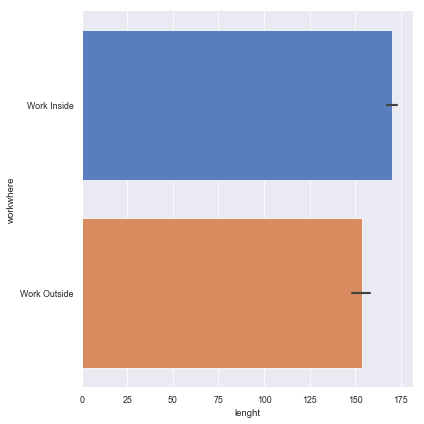

In [12]:
g = sns.catplot(x="lenght", y="workwhere", data=df, height=6, kind="bar", palette="muted")

## 2) Pre-processing (tokenization, stopword, lemmatization)

In order to process the text we first need to perform the following steps:
* **Tokenization** is the process of splitting sentences into words
* **Lemmatization** is the process of grouping together words from different forms so they can be analysed as a single item (e.g. better -> good)
* **Stop works** is the process of removing commonly used English words like “I”, “he”, “my”, “and” etc. as well as any symbols and punctuations.


In [13]:
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

my_sw = ['Ahmad', 'omit']

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2 and token not in my_sw
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text = re.sub("(\\d|\\W)+"," ",text)
  text = re.sub(r'[^\x00-\x7f]',r'', text) 
  clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
  clean_text2 = [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)

In [14]:
cleantext = clean_txt(text)
print("There are a total of {} words in all 1405 responses after cleaning.".format(len(cleantext)))

There are a total of 111775 words in all 1405 responses after cleaning.


Let's see an example of what it means to pre-process a response

In [15]:
df.openquestion[3]

'I came to Jordan and then got married and started thinking of ways to finance my family. I applied and recently got a job in recycling. it is a good job and I am happy with it. I get good pay of 270 JD a month. I am advising my friends to apply'

In [16]:
clean_txt(df.openquestion[3])

'come jordan get marry start think ways finance family apply recently get job recycle good job happy get good pay month advise friends apply'

as we can see, we don't want/need to always use cleaned text. We create a new variable with cleaned text.

In [17]:
df['openquestion3'] = df.openquestion2.apply(clean_txt)

## 3) Expanatory analysis
### Word cloud

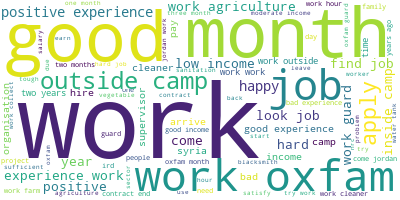

In [18]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(cleantext)
# Visualize the word cloud
wordcloud.to_image()

### Bags of Words (or how frequently words are showing up in the text)

Bag of Words is a technique used in Natural Language Processing by constructing a histogram counting all the words in our document (not taking into account the word order and syntax rules).

What are the 10 most frequently used words?

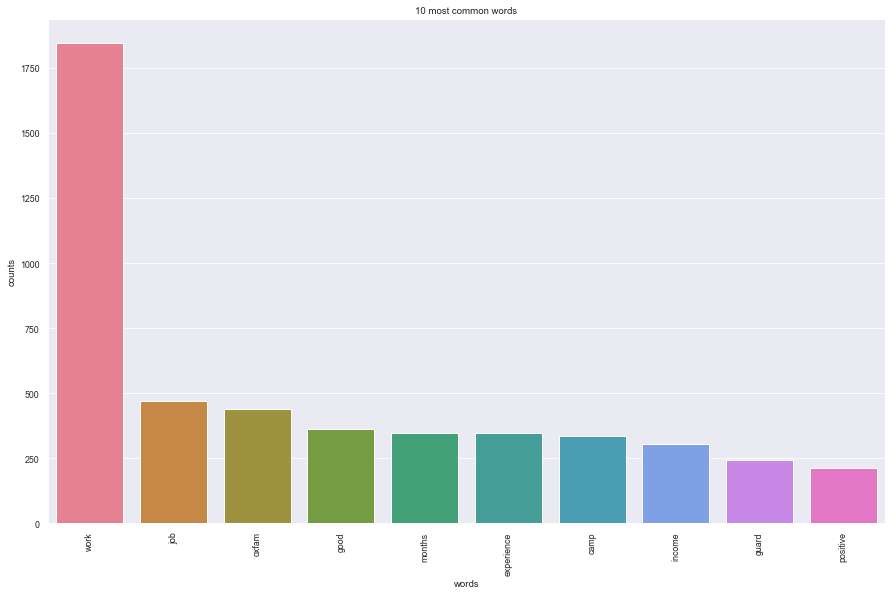

In [19]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# split() returns list of all the words in the string 
split_it = cleantext.split() 

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(split_it)

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

What are the 10 most frequently used words?

In [20]:
# Pass the split_it list to instance of Counter class. 
CounterVar = Counter(split_it)
  
# most_common() produces k frequently encountered 
most_occur = CounterVar.most_common(10) 
  
print (f"The 10 most frequent words are: {most_occur}") 

The 10 most frequent words are: [('work', 1845), ('job', 469), ('oxfam', 440), ('good', 363), ('months', 347), ('experience', 346), ('camp', 334), ('income', 304), ('guard', 244), ('positive', 213)]


and how about for un-processed text?

In [21]:
split_it_text = text.split() 
CounterVar_text = Counter(split_it_text)
most_occur_text = CounterVar_text.most_common(10) 
print (f"The 10 most frequent words for un-processed text are: {most_occur_text}") 

The 10 most frequent words for un-processed text are: [('and', 2370), ('I', 2029), ('a', 1759), ('in', 1298), ('the', 1127), ('worked', 948), ('was', 943), ('with', 933), ('to', 907), ('for', 877)]


as we can see, we want/need to use pre-processed text.

#### Word frequency by `workyn`
Are these words different on whether the respondend did carry out the work in the end? (variable `workyn`)

In [22]:
def mostfrequword (var, val):
    df2 = df[df[var]==val]
    text2 = " ".join(msg for msg in df2.openquestion)
    cleantext2 = clean_txt(text2)
    split_it2 = cleantext2.split()
    CounterVars2 = Counter(split_it2)
    most_occur_5 = CounterVars2.most_common(5) 
    print(f"For {val} the 5 most frequent words are {most_occur_5}")

In [23]:
mostfrequword('workyn', 'Yes')
mostfrequword('workyn', 'No')

For Yes the 5 most frequent words are [('work', 1499), ('oxfam', 352), ('job', 346), ('good', 305), ('months', 287)]
For No the 5 most frequent words are [('work', 346), ('job', 123), ('experience', 96), ('oxfam', 88), ('apply', 75)]


### Contains specific words
Are respondents who carried out work more likely to mention the word _"good"_?

In [24]:
df['good'] = df['openquestion2'].str.contains("good")
df.good.describe()

count      1405
unique        2
top       False
freq       1091
Name: good, dtype: object

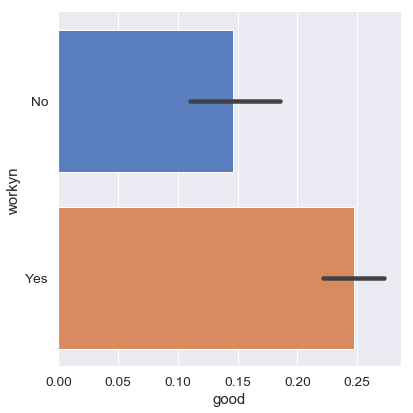

In [25]:
g = sns.catplot(x="good", y="workyn", data=df, height=6, kind="bar", palette="muted")

## 4) LDA model training

Latent Dirichlet Allocation (LDA) is a type of Topic Modelling technique. Topic Modelling is a field of research focused on finding out ways to cluster documents in order to discover latent distinguishing markers which can characterize them based on their content. Topic Modelling can also be considered as a dimensionality reduction technique since it allows us to reduce our initial data to a limited set of clusters.

In this example we try to identify 10 words in 5 topics.

In [26]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
income years come low health school hire end start search

Topic #1:
good outside agriculture bad happy family cleaner water farm tough

Topic #2:
work camp look contract jordan year project moderate collect negative

Topic #3:
oxfam months positive month pay hard try syria people luck

Topic #4:
job experience guard apply arrive inside ago need supervisor time


## 5) Sentiment analysis

Sentiment Analysis is an NLP technique commonly used in order to understand if some form of text expresses positive, negative or neutral sentiment about a topic. This can be particularly useful to do when for example trying to find out what is the general public opinion (through online reviews, tweets, etc…) about a topic, product or a company.

Let's do some sentiment analysis computing Polarity and Subjectivity.
* The polarity score is a float within the range (-1.0, 1.0), with negative values associated with more negative words, and positive values associated with positive words.
* The subjectivity score is a float with range (0.0, 1.0), with 0 being very objective and 1 very subjective

In [27]:
def evaluate_polarity(text):
  return TextBlob(text).sentiment[0]

def evaluate_subjectivity(text):
  return  TextBlob(text).sentiment[1]

In [28]:
%%time
df['polarity'] = df.openquestion3.apply(evaluate_polarity)
df['subjectivity'] = df.openquestion3.apply(evaluate_subjectivity)

Wall time: 1.3 s


In [29]:
measures = ['polarity', 'subjectivity']
df[measures].describe()

,polarity,subjectivity
count,1405.000000,1405.000000
mean,0.115902,0.408697
std,0.295597,0.256760
min,-0.700000,0.000000
25%,0.000000,0.225000
50%,0.033333,0.450000
75%,0.286869,0.584848
max,1.000000,1.000000


#### Polarity
Is the polarity score (use of positive or negative words) different whether the respondent obtained the job?

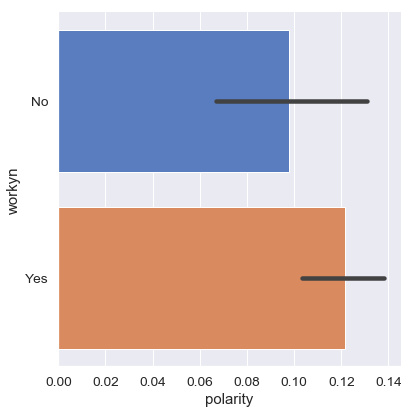

In [30]:
g = sns.catplot(x="polarity", y="workyn", data=df, height=6, kind="bar", palette="muted")

#### Subjectivity
Is the subjectivity score (objective or subjective sentences) different depending on the type of job?

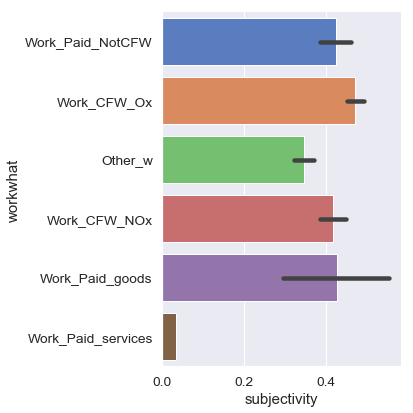

In [31]:
g = sns.catplot(x="subjectivity", y="workwhat", data=df, height=6, kind="bar", palette="muted")

## 6) Visualizations

### Histograms

**outcome** In your story, from a scale to 0 to 100, up to which extend did you achieve your objective? Where 0 is `entirely` and 100 `not at all`

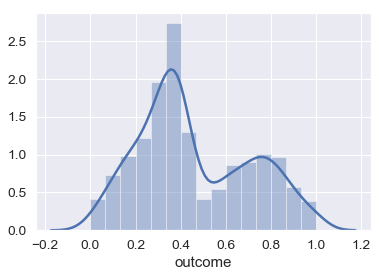

In [32]:
x = df.outcome.fillna(df.outcome.median())
sns.distplot(x)

Does this differ if the repondend obtained the job?

Text(0.5, 1.0, 'Outcome if carried out work')

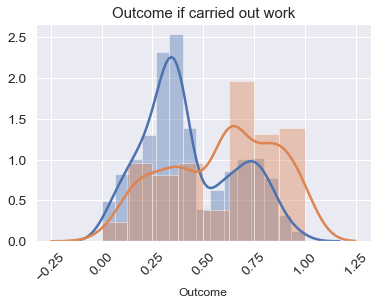

In [33]:
work_y = df[df['workyn']=='Yes']
x_1 = work_y.outcome.fillna(work_y.outcome.median())

work_n = df[df['workyn']=='No']
x_2 = work_n.outcome.fillna(work_n.outcome.median())

sns.distplot(x_1, label = 'Outcome if Work Yes')
sns.distplot(x_2, label = 'Outcome if Work No')


plt.xticks(rotation=45)
plt.xlabel("Outcome", fontsize= 12)
plt.title("Outcome if carried out work", fontsize= 15)

### Joint plot

How are the variables `outcome` and `recomend` interconnected? 

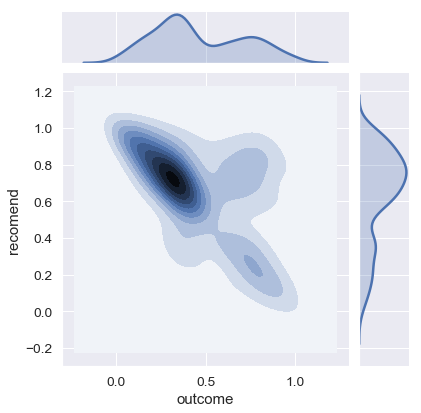

In [34]:
sns.jointplot(x="outcome", y="recomend", data=df, kind="kde");

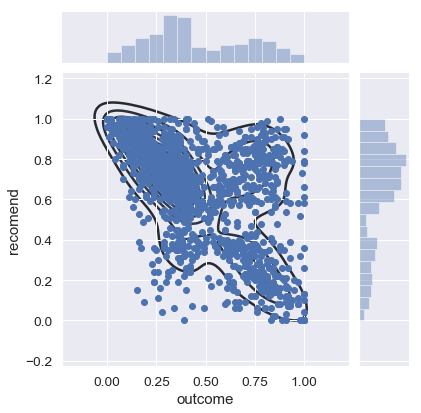

In [35]:
g = (sns.jointplot(x="outcome", y="recomend", data=df)
     .plot_joint(sns.kdeplot, zorder=0, n_levels=10))